In [1]:
import os

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from matplotlib.patches import Patch

import matching.glema.common.utils.arg_utils as arg_utils
import matching.glema.common.utils.io_utils as io_utils
import matching.glema.common.utils.misc_utils as misc_utils
import matching.glema.common.utils.plot_utils as plot_utils
import matching.glema.data.process.import_dataset as cpg_importer
import matching.misc.cpg_const as cpg_const
from matching.glema.common.utils.plot_utils import ColorScheme

In [2]:
args = arg_utils.parse_args( use_default=True )
import_dir = io_utils.get_abs_file_path( args.import_dir, with_subproject=False )
list_datasets = os.listdir( import_dir )
prefixes = [ "cpp", "java" ]
list_datasets = [ d for d in list_datasets if d.startswith( tuple( prefixes ) ) ]
list_datasets

['java_patterns-decorator.gml',
 'java_patterns-observer.gml',
 'java_patterns-adapter.gml',
 'cpp_patterns-decorator.gml',
 'cpp_patterns-adapter.gml',
 'java_patterns-abstract-factory.gml',
 'cpp_patterns-builder.gml',
 'java_patterns-factory-method.gml',
 'cpp_patterns-observer.gml',
 'java_patterns-builder.gml',
 'cpp_patterns-abstract-factory.gml',
 'cpp_patterns-factory-method.gml']

In [14]:
DESIGN_PATTERN_MAPPING = {
    cpg_const.DesignPatternType.ABSTRACT_FACTORY.value: "Abstract Factory",
    #cpg_const.DesignPatternType.ADAPTER.value: "Adapter",
    cpg_const.DesignPatternType.BUILDER.value: "Builder",
    cpg_const.DesignPatternType.FACADE.value: "Facade",
    cpg_const.DesignPatternType.FACTORY_METHOD.value: "Factory Method",
    #cpg_const.DesignPatternType.OBSERVER.value: "Observer",
    cpg_const.DesignPatternType.SINGLETON.value: "Singleton",
    cpg_const.DesignPatternType.DECORATOR.value: "Decorator",
    cpg_const.DesignPatternType.MEMENTO.value: "Memento",
    cpg_const.DesignPatternType.PROTOTYPE.value: "Prototype",
    cpg_const.DesignPatternType.PROXY.value: "Proxy",
    cpg_const.DesignPatternType.VISITOR.value: "Visitor",
    cpg_const.NO_DESIGN_PATTERN: "None",
}

DIFF_KEY = "diff"
CPP_DATASET = "cpp"
JAVA_DATASET = "java"
DATASETS = [ JAVA_DATASET, CPP_DATASET ]

DATASET_MAPPING = {
    JAVA_DATASET: "Java",
    CPP_DATASET: "C++"
}

METRIC_COL_MAPPING = {
    CPP_DATASET: DATASET_MAPPING[ CPP_DATASET ],
    JAVA_DATASET: DATASET_MAPPING[ JAVA_DATASET ],
    DIFF_KEY: "Diff",
}

records_metric = "Records (Total)"
interactions_metric = "Interactions (Total)"
language_key = "Language"

INTERACTION_MAPPING = {
    cpg_const.NodeLabel.RECORD.value: "Record",
    cpg_const.NodeLabel.KNOWS_RECORD.value: "Knows Record",
    cpg_const.NodeLabel.CALLS_RECORD.value: "Calls Record",
    cpg_const.NodeLabel.EXTENDED_BY_RECORD.value: "Extended by Record",
    cpg_const.NodeLabel.CREATES_RECORD.value: "Creates Record",
    cpg_const.NodeLabel.RETURNS_RECORD.value: "Returns Record",
}

INTERACTION_COLOR_MAPPING = {
    cpg_const.NodeLabel.KNOWS_RECORD.value: ColorScheme.PRIMARY,
    cpg_const.NodeLabel.CALLS_RECORD.value: ColorScheme.PRIMARY_COMP,
    cpg_const.NodeLabel.EXTENDED_BY_RECORD.value: ColorScheme.SECONDARY,
    cpg_const.NodeLabel.CREATES_RECORD.value: ColorScheme.SECONDARY_COMP,
    cpg_const.NodeLabel.RETURNS_RECORD.value: ColorScheme.HIGHLIGHT
}

INTERACTION_LEGEND = {
    ColorScheme.PRIMARY: INTERACTION_MAPPING[ cpg_const.NodeLabel.KNOWS_RECORD.value ],
    ColorScheme.PRIMARY_COMP: INTERACTION_MAPPING[ cpg_const.NodeLabel.CALLS_RECORD.value ],
    ColorScheme.SECONDARY: INTERACTION_MAPPING[ cpg_const.NodeLabel.EXTENDED_BY_RECORD.value ],
    ColorScheme.SECONDARY_COMP: INTERACTION_MAPPING[ cpg_const.NodeLabel.CREATES_RECORD.value ],
    ColorScheme.HIGHLIGHT: INTERACTION_MAPPING[ cpg_const.NodeLabel.RETURNS_RECORD.value ]
}

In [4]:
def preprocess_graph( G: nx.Graph ) -> nx.DiGraph:
    G_processed = nx.DiGraph()
    node_mapping: dict[ str, int ] = { }
    for idx, (n, data) in enumerate( G.nodes( data=True ) ):
        record_label = cpg_importer.get_record_label( data )
        record_label_idx = misc_utils.get_enum_idx( record_label )

        record_scope_attr = cpg_const.NodeAttr.SCOPED_RECORD_NAME.value
        record_scope = data[ record_scope_attr ] if record_scope_attr in data else None

        record_dataset_attr = cpg_const.NodeAttr.DATASET.value
        record_dataset = data[ record_dataset_attr ] if record_dataset_attr in data else None

        G_processed.add_node( idx,
                              label=record_label_idx,
                              record_scope=record_scope,
                              record_dataset=record_dataset )
        node_mapping[ n ] = int( idx )

    for source, target in list( G.edges() ):
        G_processed.add_edge( node_mapping[ source ], node_mapping[ target ] )

    return G_processed


graphs: dict[ str, nx.Graph ] = { }
for dataset in list_datasets:
    import_file = io_utils.get_abs_file_path( f"{args.import_dir}{dataset}", with_subproject=False )
    G = preprocess_graph( nx.read_gml( path=import_file ) )
    dataset_name = dataset.split( "." )[ 0 ]
    graphs[ dataset_name ] = G


In [5]:
def convert_edge_interactions( G: nx.DiGraph ) -> nx.DiGraph:
    G_converted = nx.DiGraph()
    for n, data in G.nodes( data=True ):
        n_label = misc_utils.get_enum_by_idx( cpg_const.NodeLabel, data[ "label" ] )
        if n_label == cpg_const.NodeLabel.RECORD:
            G_converted.add_node( n, **data )

    for source in list( G_converted.nodes ):
        for interaction in G.successors( source ):
            interaction_idx = G.nodes[ interaction ][ "label" ]
            for target in G.successors( interaction ):
                if (source, target) in list( G.edges() ):
                    continue
                G_converted.add_edge( source, target, label=interaction_idx )

    return G_converted

In [6]:
dp_graphs: dict[ str, dict[ str, nx.Graph ] ] = { }
for pattern_type in cpg_const.DesignPatternType:
    if pattern_type.value not in DESIGN_PATTERN_MAPPING.keys():
        continue
    pattern = pattern_type.value.lower()
    pattern = pattern.replace( "_", "-" )
    for dataset, G in graphs.items():
        G = convert_edge_interactions( G )
        if pattern in dataset:
            if pattern_type not in dp_graphs:
                dp_graphs[ pattern_type ] = { }
            if dataset.startswith( CPP_DATASET ):
                dp_graphs[ pattern_type ][ CPP_DATASET ] = G
            elif dataset.startswith( JAVA_DATASET ):
                dp_graphs[ pattern_type ][ JAVA_DATASET ] = G

In [7]:
def get_edge_labels( G, mapping=None ):
    edgeLabels = { }
    for edge in G.edges():
        label_idx = G[ edge[ 0 ] ][ edge[ 1 ] ][ "label" ]
        edgeLabels[ edge ] = misc_utils.get_enum_by_idx( cpg_const.NodeLabel, label_idx ).value
        if mapping is not None:
            edgeLabels[ edge ] = mapping[ edgeLabels[ edge ] ]
    return edgeLabels


def get_edge_colors( G, color_mapping ):
    edge_colors = [ ]
    for edge in G.edges():
        label_idx = G[ edge[ 0 ] ][ edge[ 1 ] ][ "label" ]
        label = misc_utils.get_enum_by_idx( cpg_const.NodeLabel, label_idx ).value
        edge_colors.append( color_mapping[ label ] )
    return edge_colors


def get_node_labels( G ):
    node_labels = { }
    for n, data in G.nodes( data=True ):
        node_labels[ n ] = data[ "record_scope" ].split( "." )[ -1 ]
    return node_labels

In [8]:
metrics = { }
for pattern, datasets in dp_graphs.items():
    if pattern not in metrics:
        metrics[ pattern ] = { }
    for dataset, G in datasets.items():
        edge_colors = get_edge_colors( G, INTERACTION_COLOR_MAPPING )
        edge_labels = get_edge_labels( G, mapping=INTERACTION_MAPPING )
        node_labels = get_node_labels( G )
        """
        plot_utils.plot_graph( G, title=f"{DESIGN_PATTERN_MAPPING[ pattern.value ]} - {DATASET_MAPPING[ dataset ]}",
                               pos=nx.circular_layout( G ), figsize=(8, 8), font_size=10, edge_width=2,
                               edgeColors=edge_colors, nodeLabels=node_labels, color_legend=INTERACTION_LEGEND )
        """
        metrics[ pattern ][ dataset ] = { }
        metrics[ pattern ][ dataset ][ records_metric ] = G.number_of_nodes()
        metrics[ pattern ][ dataset ][ interactions_metric ] = G.number_of_edges()
        for label in edge_labels.values():
            if label not in metrics[ pattern ][ dataset ]:
                metrics[ pattern ][ dataset ][ label ] = 0
            metrics[ pattern ][ dataset ][ label ] += 1

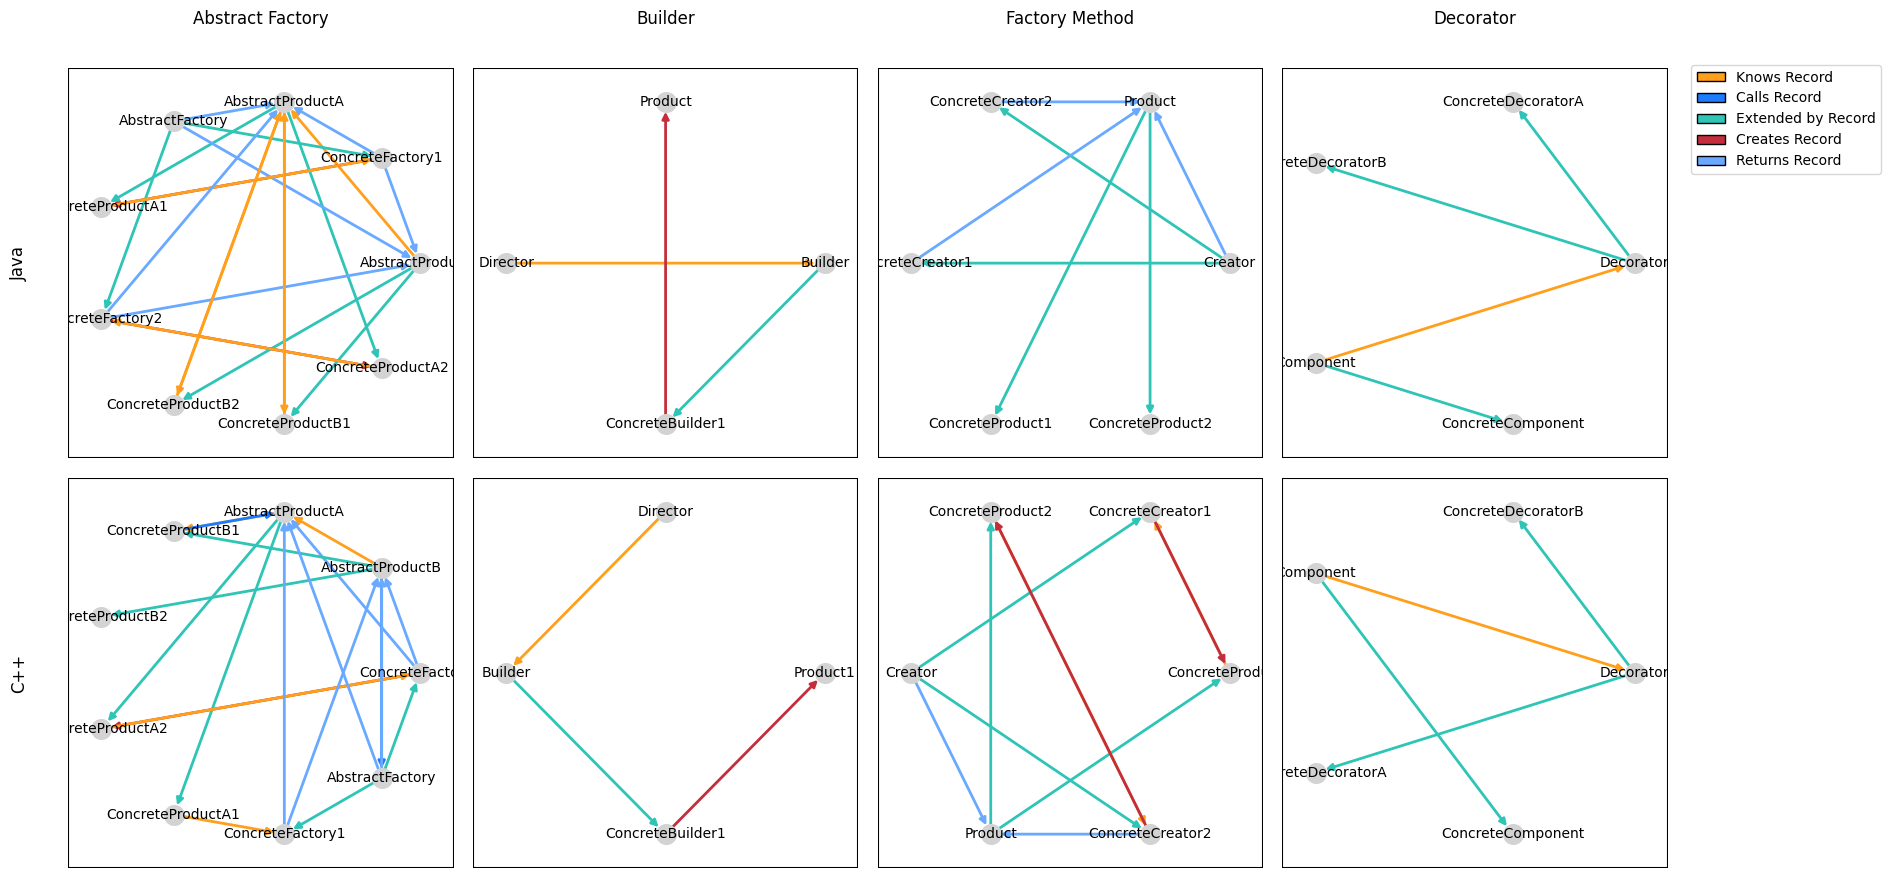

In [33]:
n = len( DATASETS )
m = len( dp_graphs.keys() )
axis_size = 5
fig, axes = plt.subplots( n, m, figsize=(axis_size * m, axis_size * n) )
for i, pattern in enumerate( dp_graphs.keys() ):
    for j, dataset in enumerate( DATASETS ):
        G = dp_graphs[ pattern ][ dataset ]
        edge_colors = get_edge_colors( G, INTERACTION_COLOR_MAPPING )
        edge_labels = get_edge_labels( G, mapping=INTERACTION_MAPPING )
        node_labels = get_node_labels( G )

        ax = axes[ j ][ i ]
        plot_utils.plot_graph( G, show_title=False, ax=ax,
                               edge_width=2, font_size=10, nodeColors=ColorScheme.GREY_LIGHT,
                               pos=nx.circular_layout( G ), 
                               edgeColors=edge_colors, nodeLabels=node_labels )

        border_width = 1.5
        line_style = "-"
        rect = patches.Rectangle( (0, 0), 1, 1, transform=ax.transAxes,
                                  fill=False, edgecolor="black", linewidth=border_width,
                                  linestyle=line_style )
        ax.add_patch( rect )

        ax.set_xticks( [ ] )
        ax.set_yticks( [ ] )

plt.subplots_adjust( left=0.1, bottom=0.1, top=0.9, right=0.9, wspace=0.05, hspace=0.05 )
# Add query (x-axis) labels at the bottom center of each column.
for i, pattern in enumerate( dp_graphs.keys() ):
    pos = axes[ 0 ][ i ].get_position()
    x = (pos.x0 + pos.x1) / 2.0
    y = pos.y1 + 0.04  # position slightly below the subplot
    fig.text( x, y, DESIGN_PATTERN_MAPPING[ pattern.value ],
              ha="center", va="bottom", fontsize=12 )

# Add source (y-axis) labels at the left center of each row.
for j, dataset in enumerate( DATASETS ):
    pos = axes[ j ][ 0 ].get_position()
    x = pos.x0 - 0.02  # position slightly left of the subplot
    y = (pos.y0 + pos.y1) / 2.0
    fig.text( x, y, DATASET_MAPPING[ dataset ],
              ha="right", va="center", fontsize=12, rotation='vertical' )

legend_elements = [ Patch( facecolor=color, edgecolor='black', label=label )
                    for color, label in INTERACTION_LEGEND.items() ]
legend_pos = axes[ 0 ][ -1 ].get_position()
axis_delta = legend_pos.x1 - legend_pos.x0
legend_pos.y1 += 0.01
legend_pos.x0 += 0.11
legend_pos.x1 += 0.11
fig.legend( handles=legend_elements, bbox_to_anchor=legend_pos )

plt.savefig( f"plots/language_comparison.png", bbox_inches='tight', pad_inches=0.1 )

In [13]:
metric_names = [ records_metric, interactions_metric, *INTERACTION_LEGEND.values() ]
metric_diffs = { }
for pattern, datasets in metrics.items():
    metric_diffs[ pattern ] = { }

    for metric in metric_names:
        metric_a = datasets[ CPP_DATASET ].get( metric, 0 )
        metric_b = datasets[ JAVA_DATASET ].get( metric, 0 )
        metric_diffs[ pattern ][ metric ] = abs( metric_a - metric_b )

for pattern, datasets in metrics.items():
    metrics[ pattern ][ DIFF_KEY ] = metric_diffs[ pattern ]
metrics

{<DesignPatternType.ABSTRACT_FACTORY: 'ABSTRACT_FACTORY'>: {'java': {'Records (Total)': 9,
   'Interactions (Total)': 21,
   'Extended by Record': 6,
   'Knows Record': 7,
   'Returns Record': 6,
   'Creates Record': 2},
  'cpp': {'Records (Total)': 9,
   'Interactions (Total)': 19,
   'Returns Record': 6,
   'Creates Record': 1,
   'Knows Record': 4,
   'Extended by Record': 6,
   'Calls Record': 2},
  'diff': {'Records (Total)': 0,
   'Interactions (Total)': 2,
   'Knows Record': 3,
   'Calls Record': 2,
   'Extended by Record': 0,
   'Creates Record': 1,
   'Returns Record': 0}},
 <DesignPatternType.BUILDER: 'BUILDER'>: {'cpp': {'Records (Total)': 4,
   'Interactions (Total)': 3,
   'Knows Record': 1,
   'Extended by Record': 1,
   'Creates Record': 1},
  'java': {'Records (Total)': 4,
   'Interactions (Total)': 3,
   'Extended by Record': 1,
   'Knows Record': 1,
   'Creates Record': 1},
  'diff': {'Records (Total)': 0,
   'Interactions (Total)': 0,
   'Knows Record': 0,
   'Calls 

In [11]:
metric_df_data = { "Measure": metric_names }
for pattern in metrics.keys():
    for col in METRIC_COL_MAPPING.keys():
        col_name = f"{DESIGN_PATTERN_MAPPING[ pattern.value ]} ({METRIC_COL_MAPPING[ col ]})"
        col_metrics = metrics[ pattern ][ col ]
        col_values = [ col_metrics.get( metric, 0 ) for metric in metric_names ]
        metric_df_data[ col_name ] = col_values

metric_df = pd.DataFrame( data=metric_df_data )
metric_df.to_csv( f"tables/language_difference.csv", index=False )
metric_df

,Measure,Abstract Factory (C++),Abstract Factory (Java),Abstract Factory (Diff),Builder (C++),Builder (Java),Builder (Diff),Factory Method (C++),Factory Method (Java),Factory Method (Diff),Decorator (C++),Decorator (Java),Decorator (Diff)
0,Records (Total),9,9,0,4,4,0,6,6,0,5,5,0
1,Interactions (Total),19,21,2,3,3,0,10,7,3,4,4,0
2,Knows Record,4,7,3,1,1,0,2,0,2,1,1,0
3,Calls Record,2,0,2,0,0,0,0,0,0,0,0,0
4,Extended by Record,6,6,0,1,1,0,4,4,0,3,3,0
5,Creates Record,1,2,1,1,1,0,2,0,2,0,0,0
6,Returns Record,6,6,0,0,0,0,2,3,1,0,0,0


In [30]:
pattern_dfs = {}
cols = [ language_key, *metric_names ]
for pattern in metrics.keys():
    pattern_df_data = {}
    for dataset in METRIC_COL_MAPPING.keys():
        for col in cols:
            if col not in pattern_df_data:
                pattern_df_data[col] = []
            if col == language_key:
                pattern_df_data[col].append( METRIC_COL_MAPPING[dataset] )
            else:
                pattern_df_data[col].append( metrics[ pattern ][ dataset ].get( col, 0 ) )   
    pattern_df_data = pd.DataFrame( data=pattern_df_data )
    pattern_df_data.to_csv( f"tables/language_difference_{pattern.value}.csv", index=False )
    pattern_dfs[ DESIGN_PATTERN_MAPPING[ pattern.value ] ] = pattern_df_data
pattern_dfs[ "Builder" ]

,Language,Records (Total),Interactions (Total),Knows Record,Calls Record,Extended by Record,Creates Record,Returns Record
0,C++,4,3,1,0,1,1,0
1,Java,4,3,1,0,1,1,0
2,Diff,0,0,0,0,0,0,0
